# LastFM dataset

In [1]:
import numpy as np
import pandas as pd
from interactions_data import make_long
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
import zipfile
import os, shutil

In [2]:
# try:
#     shutil.rmtree('./bookcrossing')
#     print('bookcrossing directory already exists, removing it first')
# except:
#     print('no existing directory found, all good')

# stable link for dataset
url = 'http://files.grouplens.org/datasets/hetrec2011/'
filename = 'hetrec2011-lastfm-2k.zip'

# download zip file from link
print('downloading and saving dataset from book-crossing stable link...')
downloaded = urlopen(url + filename)
buf = downloaded.read()

# save file and extract contents
with open(filename, 'wb') as f:
    f.write(buf)

print('unzipping contents')
with zipfile.ZipFile(filename) as zip:
    zip.extractall('./lastfm')
    
# add .txt to readme file
# os.rename('./ml-1m/README', './ml-1m/README.txt')

# remove zip file from directory
print('deleting zip file')
os.remove(filename)

downloading and saving dataset from book-crossing stable link...
unzipping contents
deleting zip file


In [3]:
path = 'lastfm/'

In [4]:
df = pd.read_csv(path+'user_artists.dat',sep='\t')
df.columns = ['userId','artistId','playcount']
df.head()

,userId,artistId,playcount
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [5]:
df.shape

(92834, 3)

In [6]:
artists = pd.read_csv(path+'artists.dat',
                      sep='\t')
artists.columns = ['artistId', 'name', 'url', 'pictureUrl']

tags = pd.read_csv(path+'tags.dat',
                   sep='\t',
                   encoding='latin')
tags.columns = ['tagId', 'tagValue']

user_tags = pd.read_csv(path+'user_taggedartists.dat',
                        sep='\t')
user_tags.columns = ['userId', 'artistId', 'tagId', 'day', 'month', 'year']

user_friends = pd.read_csv(path+'user_friends.dat',
                           sep='\t')
user_friends.columns = ['userId', 'friendId']

In [7]:
artists.head()

,artistId,name,url,pictureUrl
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [8]:
artists.shape

(17632, 4)

In [9]:
tags.head()

,tagId,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [10]:
tags.shape

(11946, 2)

In [11]:
user_tags['date'] = pd.to_datetime(user_tags[['year','month','day']])
user_tags.drop(['day','month','year'], axis=1, inplace=True)
user_tags.head()

,userId,artistId,tagId,date
0,2,52,13,2009-04-01
1,2,52,15,2009-04-01
2,2,52,18,2009-04-01
3,2,52,21,2009-04-01
4,2,52,41,2009-04-01


In [12]:
user_tags.shape

(186479, 4)

In [13]:
user_friends.head()

,userId,friendId
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831


In [14]:
user_friends.shape

(25434, 2)

In [15]:
user_ids = df['userId'].unique()
artist_ids = df['artistId'].unique()

In [16]:
# length before
print(len(artists), len(user_tags), len(user_friends))

# keep metadata only for artists that have been listened to
artists = artists[artists['artistId'].isin(artist_ids)]
user_tags = user_tags[user_tags['userId'].isin(user_ids)]
user_tags = user_tags[user_tags['artistId'].isin(artist_ids)]
user_friends = user_friends[user_friends['userId'].isin(user_ids)]
user_friends = user_friends[user_friends['friendId'].isin(user_ids)]

# length after
print(len(artists), len(user_tags), len(user_friends))

17632 186479 25434
17632 184941 25434


### Encode IDs from 0-n

In [17]:
def create_encoder(data, start=0):

    encoder = {}

    idx = start
    for item in data:

        if item not in encoder.keys():
            encoder[item] = idx
            idx += 1

    return encoder

In [18]:
# create ID encoders
user_encoder = create_encoder(user_ids)
artist_encoder = create_encoder(artist_ids)

In [19]:
# replace all IDs with sequential 0-N IDs
df['userId'] = df['userId'].apply(lambda x: user_encoder[x])
df['artistId'] = df['artistId'].apply(lambda x: artist_encoder[x])

In [20]:
user_tags['userId'] = user_tags['userId'].apply(lambda x: user_encoder[x])
user_tags['artistId'] = user_tags['artistId'].apply(lambda x: artist_encoder[x])
user_friends['userId'] = user_friends['userId'].apply(lambda x: user_encoder[x])
user_friends['friendId'] = user_friends['friendId'].apply(lambda x: user_encoder[x])
artists['artistId'] = artists['artistId'].apply(lambda x: artist_encoder[x])

In [21]:
n_users = df.userId.nunique()
n_items = df.artistId.nunique()
max_score = df.playcount.max()
min_score = df.playcount.min()

In [22]:
print(n_users, df.userId.max())
print(n_items, df.artistId.max())
print(min_score, max_score)

1892 1891
17632 17631
1 352698


### Train / test split
Now that the IDs have been encoded sequentially, we can split the data into train and test sets and save them.

In [23]:
train, test, _, _ = train_test_split(df, df.playcount,
                                     test_size = .2,
                                     random_state=42)

In [24]:
train.shape

(74267, 3)

In [25]:
test.shape

(18567, 3)

In [26]:
train.to_csv(path+'train.csv', index=False)
test.to_csv(path+'test.csv', index=False)

In [27]:
artists.to_csv(path+'artists.csv', index=False)
tags.to_csv(path+'tags.csv', index=False)
user_tags.to_csv(path+'user_tags.csv', index=False)
user_friends.to_csv(path+'user_friends.csv', index=False)

### remove all other files

In [28]:
folder = os.listdir('./'+path)

for item in folder:
    if not (item.endswith("train.csv") or item.endswith("test.csv")):
        os.remove(os.path.join('./'+path, item))

## EDA

In [29]:
df.head()

,userId,artistId,playcount
0,0,0,13883
1,0,1,11690
2,0,2,11351
3,0,3,10300
4,0,4,8983


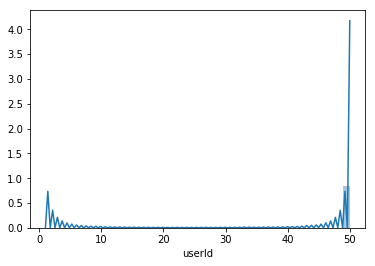

Min artists by single user: 1
Max artists by single user: 50
Avg number of artists per user: 49


In [30]:
user_counts = df['userId'].value_counts()

sns.distplot(user_counts)
plt.show()

# user with fewest artists
print('Min artists by single user:',
      user_counts.min())

# user with most artists
print('Max artists by single user:',
      user_counts.max())

# average number of artists per user
print('Avg number of artists per user:',
      round(user_counts.mean()))

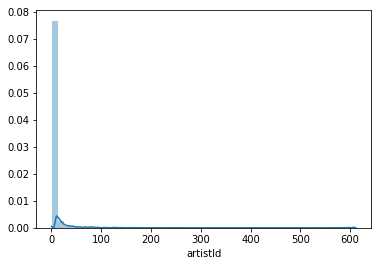

Min users per artist: 1
Max users per artist: 611
Avg users per artist: 5


In [31]:
artist_counts = df['artistId'].value_counts()

sns.distplot(artist_counts)
plt.show()

# artist with fewest appearances
print('Min users per artist:',
      artist_counts.min())

# artist with most appearances
print('Max users per artist:',
      artist_counts.max())

# average number of ratings per book
print('Avg users per artist:',
      round(artist_counts.mean()))

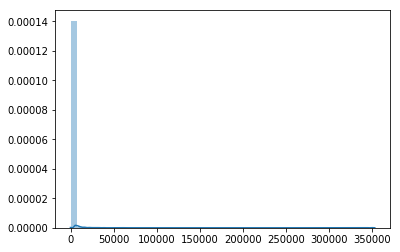

Avg playcount: 745.24


In [32]:
sns.distplot(df['playcount'].values)
plt.show()

print('Avg playcount:', round(df['playcount'].mean(),2))